In [3]:
#%% Import data and define categories
import pandas as pd
import numpy as np
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import bayesian_search_forecaster
import time
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.compose import ColumnTransformer
from math import sqrt

#For plot:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

In [ ]:
name = "LSTM_error"

In [ ]:
data_type = "ind"

In [4]:
df = pd.read_csv("/work/Master project/data/data_5_clean.csv")

df = df
df = df.set_index('date')

num_cols = ['air_temp','humidity','solar_radiation','dew_point_temp']
remainder_cols = ['hour_sin','hour_cos','week_sin','week_cos','month_sin','month_cos','day_of_the_week_sin','day_of_the_week_cos','is_weekend' ]

print("Min Date:", df.index.min())
print("Max Date:", df.index.max())

Min Date: 01/01/2021 00:00
Max Date: 31/12/2023 23:00


In [5]:

df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')
data = df.loc['2021-01-01 00:00:00': '2023-12-31 23:00:00'].copy()
data.index = pd.to_datetime(data.index)
data = data.resample("H").sum()

# Choose colomns
data = data[["electricity_cons", "hour_sin", "hour_cos", 'day_of_the_week_sin','day_of_the_week_cos','is_weekend', 'month_cos', 'month_sin','week_sin','week_cos','air_temp','humidity','solar_radiation','dew_point_temp']]

end_train = '2022-10-31 23:00:00'
end_validation = '2022-12-31 23:00:00'

data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(len(data_train))
print(len(data_val))
print(len(data_test))

#n_backtest = 365*24-12 # Last 9 years are used for backtest
#data_train = X[:-n_backtest]
#data_validate = 
#data_backtest = X[-n_backtest:]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

data = data.resample("H").sum()

16056
1465
8761
Train dates      : 2021-01-01 00:00:00 --- 2022-10-31 23:00:00  (n=16056)
Validation dates : 2022-10-31 23:00:00 --- 2022-12-31 23:00:00  (n=1465)
Test dates       : 2022-12-31 23:00:00 --- 2023-12-31 23:00:00  (n=8761)


In [6]:
Transform_exog = ColumnTransformer(
    [('scale', StandardScaler(),['air_temp','humidity','solar_radiation','dew_point_temp'])
    ],
     remainder = 'passthrough'
     )

In [7]:
def custom_predictors(y):
    lags = y[[-1,-2,-3,-4,-5,-23,-24,-25,-47,-48,-49]]     # window size needed = 49
    mean_24 = np.mean(y[-24:]) # window size needed = 24
    mean_48 = np.mean(y[-48:]) # window size needed = 48
    predictors = np.hstack([lags, mean_24, mean_48])
    
    return predictors

In [6]:
forecaster = ForecasterAutoregCustom(
                 regressor         = RandomForestRegressor(),
                 fun_predictors    = custom_predictors,
                 window_size       = 49,
                 transformer_y     = StandardScaler(),
                 transformer_exog  = Transform_exog,
                 name_predictors = [f'lag {i}' for i in range(1, 6)] + ['lag 23','lag 24','lag 25','lag 47','lag 48','lag 49','moving_avg_24','moving_avg_48'],
             )

In [7]:
t0 = time.time()

# Lags used as predictors
#lags_grid = [24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'  : trial.suggest_int('n_estimators', 40, 90, step= 10),
        'max_depth'     : trial.suggest_int('max_depth', 4, 12, step=2),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 8, step=2),
        'n_jobs' : trial.suggest_int('n_jobs', -1,-1),
    } 
    return search_space


results_search, frozen_trial = bayesian_search_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.loc[: end_validation, 'electricity_cons'],
                                   steps              = 24,
                                   metric             = 'mean_absolute_error',
                                   exog               = data.loc[: end_validation, num_cols+remainder_cols],
                                   search_space       = search_space,
                                   initial_train_size = len(data_train)+12,
                                   gap                = 12,
                                   fixed_train_size   = True,
                                   refit              = 1,
                                   n_trials           = 10, # Increase for more exhaustive search
                                   return_best        = True,
                                   n_jobs             = -1,
                                   verbose            = False,
                                   show_progress      = True
)


t1 = time.time()

total = t1-t0

Number of models compared: 10,
         10 bayesian search in each lag configuration.


lags grid:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning: The forecaster will be fit 60 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning: The forecaster will be fit 60 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning: The forecaster will be fit 60 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefi

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'n_estimators': 70, 'max_depth': 10, 'min_samples_leaf': 4, 'n_jobs': -1}
  Backtesting metric: 19.49897034969284



In [8]:
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

save_forecaster(forecaster, file_name='Models/{}'.format(name), verbose=False)

X_train, y_train = forecaster.create_train_X_y(y=data.loc[:end_validation, 'electricity_cons'], exog=data.loc[:end_validation, num_cols+remainder_cols],)

X_train.head(5)
y_train.head(5)




NameError: name 'forecaster' is not defined

In [9]:
metric, predictions = backtesting_forecaster(
                          forecaster            = forecaster,
                          y                     = data['electricity_cons'],
                          exog                  = data[num_cols+remainder_cols],
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          initial_train_size    = len(data[:end_validation])+12,
                          fixed_train_size      = True,
                          gap                   = 12,
                          allow_incomplete_fold = True,
                          refit                 = 1,
                       #   interval              = [5, 95],
                          n_jobs                = 'auto',
                        #  n_boot                = 100,
                          verbose               = False,
                          show_progress         = True
                      )

print(f"Backtest error: {metric:.2f}")
predictions.head()


ForecasterAutoregCustom 
Regressor: RandomForestRegressor(max_depth=10, min_samples_leaf=4, n_estimators=70,
                      n_jobs=-1) 
Predictors created with function: custom_predictors 
Transformer for y: StandardScaler() 
Transformer for exog: ColumnTransformer(remainder='passthrough',
                  transformers=[('scale', StandardScaler(),
                                 ['air_temp', 'humidity', 'solar_radiation',
                                  'dew_point_temp'])]) 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['air_temp', 'humidity', 'solar_radiation', 'dew_point_temp', 'hour_sin', 'hour_cos', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'day_of_the_week_sin', 'day_of_the_week_cos', 'is_weekend'] 
Training range: [Timestamp('2021-01-01 00:00:00'), Timestamp('2022-12-31 23:00:00')] 
Training index type: Dateti

/opt/conda/lib/python3.10/site-packages/skforecast/model_selection/model_selection.py:548: LongTrainingWarning: The forecaster will be fit 364 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(


  0%|          | 0/364 [00:00<?, ?it/s]

Backtest error: 20.64


,pred
2023-01-02 00:00:00,113.079518
2023-01-02 01:00:00,107.142744
2023-01-02 02:00:00,45.562703
2023-01-02 03:00:00,59.822763
2023-01-02 04:00:00,64.834514


In [10]:
def evaluate_forecast(actual, predicted):
    scores = list()
    
	# calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
		# calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
        rmse = sqrt(mse)
		# store (changede to mse since it otherwise would not make sense on the plot)
        scores.append(rmse)
    
	# calculate overall RMSE
    sum = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            sum += (actual[row, col] - predicted[row, col])**2
    score = sqrt(sum / (actual.shape[0] * actual.shape[1]))
    
    # calculate error distribution
    error_dist = np.zeros_like(actual, dtype=float)
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            squared_error = (actual[row, col] - predicted[row, col])**2
            error_dist[row, col] = sqrt(squared_error)
    return score, scores, error_dist

In [11]:
# evaluate performance
def performance(name, score, scores):
 use_scores = ', '.join(['%.1f' % s for s in scores])
 print('%s: [%.3f] %s' % (name, score, use_scores))
    
 # Creating a dictionary of the data
 data = {'Model': [name],
        'Overall RMSE-score': [score]}

 # Dynamically create columns for scores
 data.update({f'RMSE Score {i}': [scores[i-1]] for i in range(1, 25)})

 # Creating a DataFrame from the dictionary
 df = pd.DataFrame(data)
    
 # Appending the new data to the DataFrame
 df.to_csv('RF_output.csv', mode='a', index=False, header=False)
  


In [12]:
importance = forecaster.get_feature_importances()
importance = importance.sort_values(by='importance', ascending=False)
print(importance)
#varibles = forecaster.exog_col_names()


                           feature  importance
6                           lag 24    0.686232
0                            lag 1    0.223532
17             remainder__hour_sin    0.021067
7                           lag 25    0.009625
5                           lag 23    0.008500
18             remainder__hour_cos    0.007842
23  remainder__day_of_the_week_sin    0.004464
11                   moving_avg_24    0.004070
8                           lag 47    0.003635
9                           lag 48    0.003384
2                            lag 3    0.003228
24  remainder__day_of_the_week_cos    0.003131
10                          lag 49    0.002839
1                            lag 2    0.002794
4                            lag 5    0.002383
13                 scale__air_temp    0.002360
3                            lag 4    0.002053
12                   moving_avg_48    0.001719
25           remainder__is_weekend    0.001522
14                 scale__humidity    0.001196
16           

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#r2 = r2_score(data_test.loc['2023-01-02 00:00:00':,'electricity_cons'], predictions)


#print('R-squared score: ', r2)


actualss = data_test.loc['2023-01-02 00:00:00':,'electricity_cons']

#predictions = predictions['pred']
print(actualss.shape)
actualss = np.array(np.split(actualss.values, len(actualss)/24))
print(predictions.shape)
predictions = np.array(np.split(predictions, len(predictions)/24))

score, scores, error_dist = evaluate_forecast(actualss, predictions)



# summarize scores
performance(name, score, scores)


df_error_dist = pd.DataFrame(error_dist)

df_error_dist.to_csv('error_dist/{}_error_dist.csv'.format(name) , index=False)


(8736,)
(364, 24)
RF_ind: [28.401] 21.6, 24.4, 34.5, 40.1, 40.1, 31.6, 26.1, 26.0, 29.1, 30.7, 33.1, 34.7, 31.9, 26.2, 24.1, 24.5, 23.0, 22.8, 22.2, 21.0, 22.7, 25.2, 27.6, 25.5
(1, 25)


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


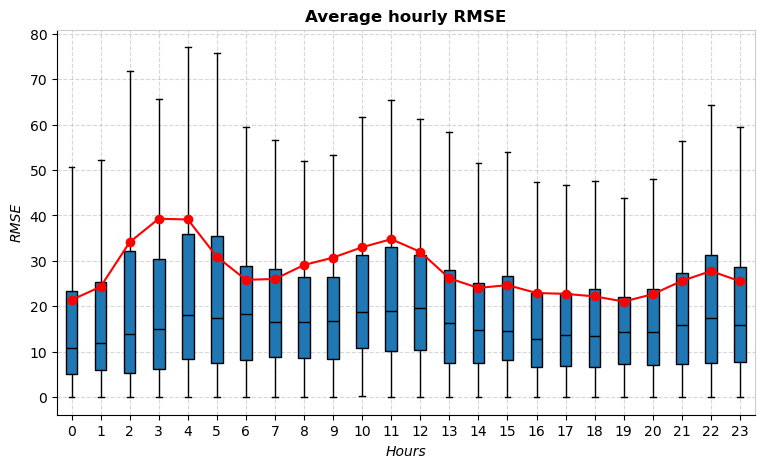

In [17]:
# plot scores

hours = ['00', '01', '02', '03', '04', '05', '06','07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20','21', '22', '23']
plt.figure(figsize=(9, 5))

boxplot_positions = np.arange(len(hours))
# Add boxplots for each column in the error_dist array
for col in range(error_dist.shape[1]):
    boxplot_values = error_dist[:, col]
    plt.boxplot(boxplot_values, positions=[col], widths=0.4, showfliers=False, patch_artist=True, medianprops=dict(color='black'))


plt.plot(hours, scores, marker='o', label='lstm', color="red")
ax = plt.subplot(111)

# set the basic lables
ax.set_xlabel('Hours')
ax.set_ylabel('RMSE')
ax.set_title('Average hourly RMSE')

# tweak the title
ttl = ax.title
ttl.set_weight('bold')

# tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)

# grid on
ax.grid('on', linestyle = "--", alpha=0.5)

# color of plot, just to be sure
ax.set_facecolor('xkcd:white')

# change the color of the top and right spines to opaque gray
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))


plt.savefig('scores/{}.png'.format(name))
plt.show()

In [18]:
import datetime
predictions = predictions.flatten()
#predictions = predictions[:-12]

actuals = actualss.flatten()
#actuals = actuals[12:]
result = pd.DataFrame({'preds': predictions, 'actuals': actuals})

start_date = '2023-01-02 00:00:00'
end_date = '2023-12-31 23:00:00'
date_format = '%Y-%m-%d %H:%M:%S'


# Create datetime index
datetime_index = pd.date_range(start=start_date, end=end_date, freq='H')

# Create DataFrame with datetime index, predictions, and actuals
resultss = pd.DataFrame({'Datetime': datetime_index, 'Preds': predictions, 'Actuals': actuals})

# Save DataFrame to CSV file
resultss.to_csv('predictions/{}_predictions_actuals.csv'.format(name), index=False)






start_datetime = datetime.datetime.strptime(start_date, date_format)
end_datetime = datetime.datetime.strptime(end_date, date_format)

date_range = pd.date_range(start=start_datetime, end=end_datetime, freq='H')

result = result.set_index(date_range)

fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=result.index,
        y=result["preds"],
        mode='lines',
    ),
    go.Scatter(
        name='Real value',
        x=result.index,
        y=result["actuals"],
        mode='lines',
     )
])


fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    plot_bgcolor='white',
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    ),
    xaxis=dict(linecolor='black',showgrid=True, gridcolor='rgba(0, 0, 0, 0.3)',griddash='dash',mirror=True),
    yaxis=dict(linecolor='black',showgrid=True, gridcolor='rgba(0, 0, 0, 0.3)',griddash='dash',mirror=True),
)

fig.show()
fig.write_html('predictions/{}.html'.format(name), auto_open=True)
